In [62]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')


In [22]:
df=pd.read_csv('Data/USA_Housing.csv')
df_copy=df.copy()

In [23]:
df_copy.head()

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,Address
0,79545.45857,5.682861,7.009188,4.09,23086.80050,1.059034e+06,"208 Michael Ferry Apt. 674\nLaurabury, NE 3701..."
1,79248.64245,6.002900,6.730821,3.09,40173.07217,1.505891e+06,"188 Johnson Views Suite 079\nLake Kathleen, CA..."
2,61287.06718,5.865890,8.512727,5.13,36882.15940,1.058988e+06,"9127 Elizabeth Stravenue\nDanieltown, WI 06482..."
3,63345.24005,7.188236,5.586729,3.26,34310.24283,1.260617e+06,USS Barnett\nFPO AP 44820
4,59982.19723,5.040555,7.839388,4.23,26354.10947,6.309435e+05,USNS Raymond\nFPO AE 09386


# ***DataPreprocessing***

#### **Split X and Y**

In [24]:
X=df_copy.drop(columns=['Price'])
Y=df_copy['Price']

#### **Split Train and Test**

In [25]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=.3,random_state=1)

#### **Null Data Percentage wise**

In [26]:
(df_copy.isnull().sum()/len(df_copy))* 100

Avg. Area Income                0.20
Avg. Area House Age             0.00
Avg. Area Number of Rooms       0.10
Avg. Area Number of Bedrooms    0.12
Area Population                 0.00
Price                           0.00
Address                         0.00
dtype: float64

#### **Identify Outlier For Applying Imputation Method**

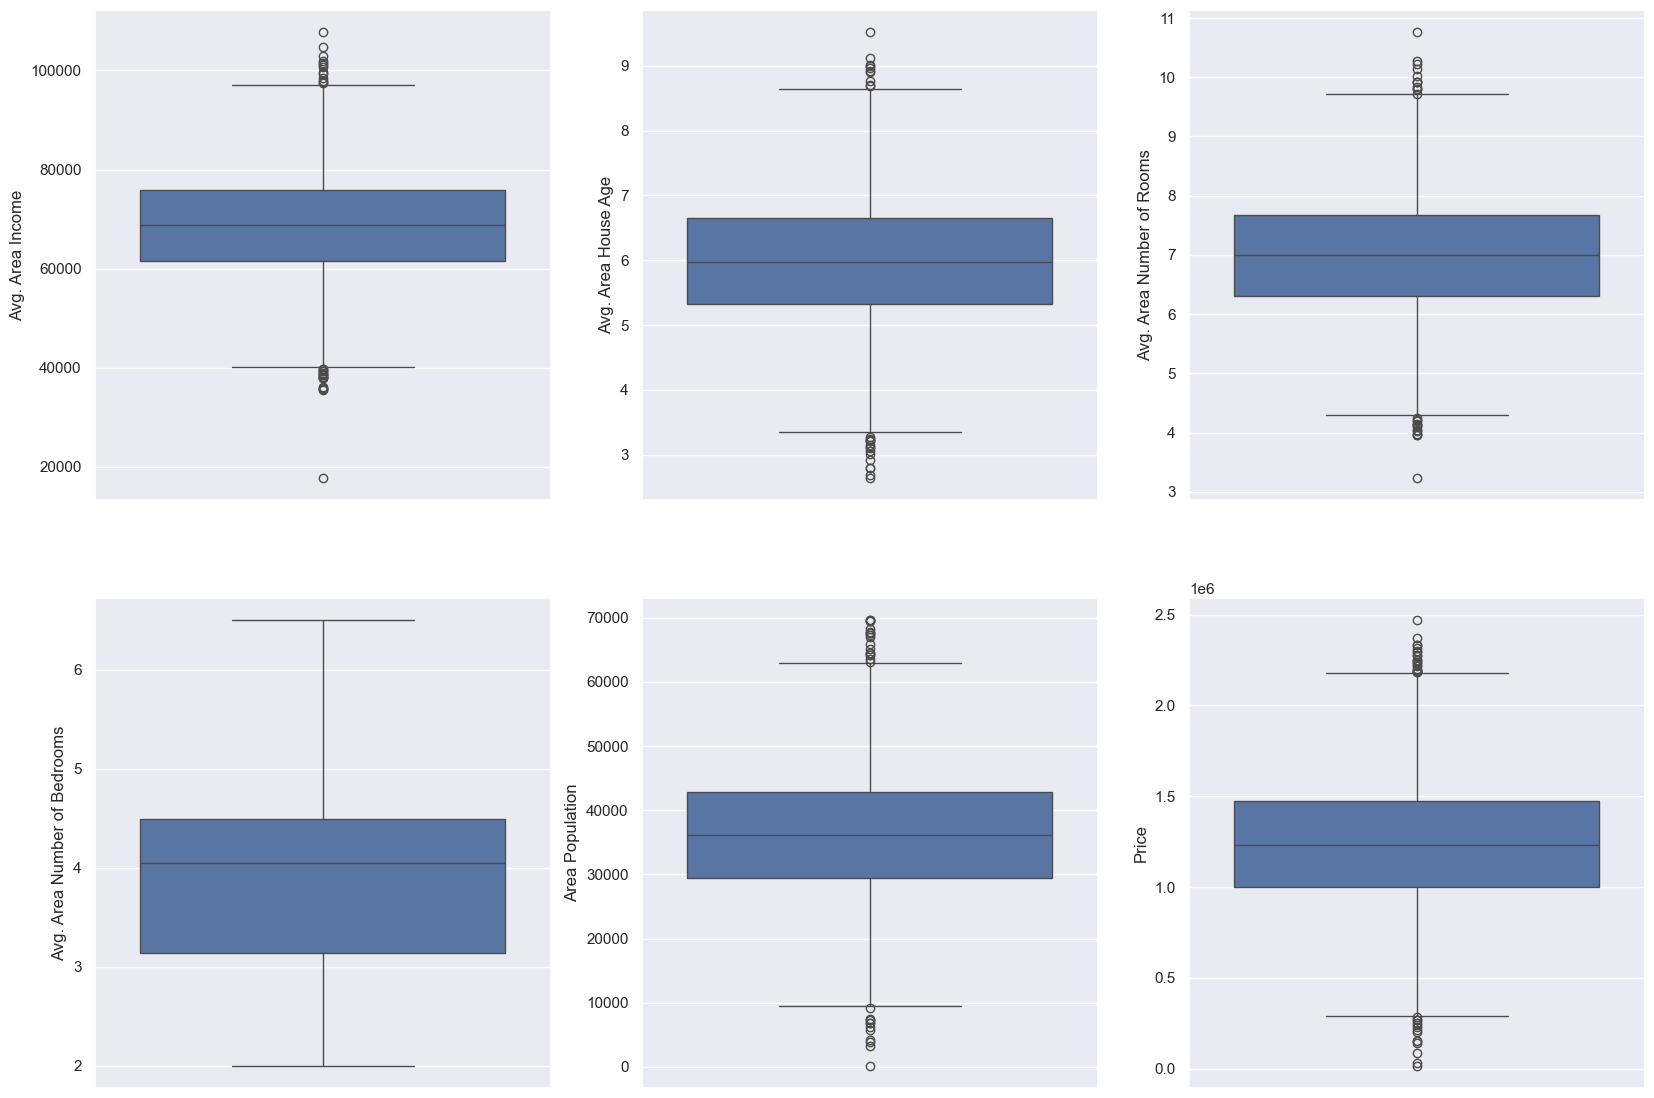

In [27]:
plt.figure(figsize=(20,14))
for i,j in enumerate(df_copy.select_dtypes(exclude='object')):
    plt.subplot(2,3,i+1)
    sns.boxplot(data=df_copy[df_copy.select_dtypes(exclude='object').columns[i]])
   

#### **Insight**

`Avg. Area Income`  and `Avg. Area Number of Rooms` can be impute by median

`Avg. Area Number of Bedrooms` can be impute by mean

In [28]:
imputer_mean=SimpleImputer(strategy='median')
X_train[['Avg. Area Income','Avg. Area Number of Rooms']]=imputer_mean.fit_transform(X_train[['Avg. Area Income','Avg. Area Number of Rooms']])
X_test[['Avg. Area Income','Avg. Area Number of Rooms']]=imputer_mean.transform(X_test[['Avg. Area Income','Avg. Area Number of Rooms']])


In [29]:
imputer_mean=SimpleImputer()
X_train[['Avg. Area Number of Bedrooms']]=imputer_mean.fit_transform(X_train[['Avg. Area Number of Bedrooms']])
X_test[['Avg. Area Number of Bedrooms']]=imputer_mean.transform(X_test[['Avg. Area Number of Bedrooms']])

In [30]:
X_test.isnull().sum()

Avg. Area Income                0
Avg. Area House Age             0
Avg. Area Number of Rooms       0
Avg. Area Number of Bedrooms    0
Area Population                 0
Address                         0
dtype: int64

In [31]:
X_train.isnull().sum()

Avg. Area Income                0
Avg. Area House Age             0
Avg. Area Number of Rooms       0
Avg. Area Number of Bedrooms    0
Area Population                 0
Address                         0
dtype: int64

## Encoding method

In [32]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Avg. Area Income              4990 non-null   float64
 1   Avg. Area House Age           5000 non-null   float64
 2   Avg. Area Number of Rooms     4995 non-null   float64
 3   Avg. Area Number of Bedrooms  4994 non-null   float64
 4   Area Population               5000 non-null   float64
 5   Price                         5000 non-null   float64
 6   Address                       5000 non-null   object 
dtypes: float64(6), object(1)
memory usage: 273.6+ KB


In [33]:
df_copy['Address'] = df_copy['Address'].astype('category')
df_copy['Address'] = df_copy['Address'].cat.codes

## Anova test : we we see address have 5000 unique values so we cant directly encode Address, so first we need to check its significance.

In [34]:
# Whether Address is significant variable or not
# check p-value
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('Price ~ Address', data = df_copy).fit()
anova_result = sm.stats.anova_lm(model, typ=2)
print(anova_result)

                sum_sq      df         F    PR(>F)
Address   4.729103e+10     1.0  0.379215  0.538051
Residual  6.232883e+14  4998.0       NaN       NaN


### p value >.05 so Address not significance with Price

# Part 3 - Outlier treatement - mandatory whenever we do linear regression model

#### Outlier Found on - 'Avg. Area Income', 'Avg. Area House Age', 'Avg. Area Number of Rooms', 'Area Population'

In [35]:
for i in df_copy[['Avg. Area Income', 'Avg. Area House Age', 'Avg. Area Number of Rooms', 'Area Population']]:
    Q1 = df_copy[i].quantile(0.25)
    Q3 = df_copy[i].quantile(0.75)
    iqr = Q3 - Q1

    ul = Q3 + 1.5 * iqr
    ll = Q1 - 1.5 * iqr
    
    df_copy[i]=np.where(df_copy[i]>ul,ul,np.where(df_copy[i]<ll,ll,df_copy[i]))

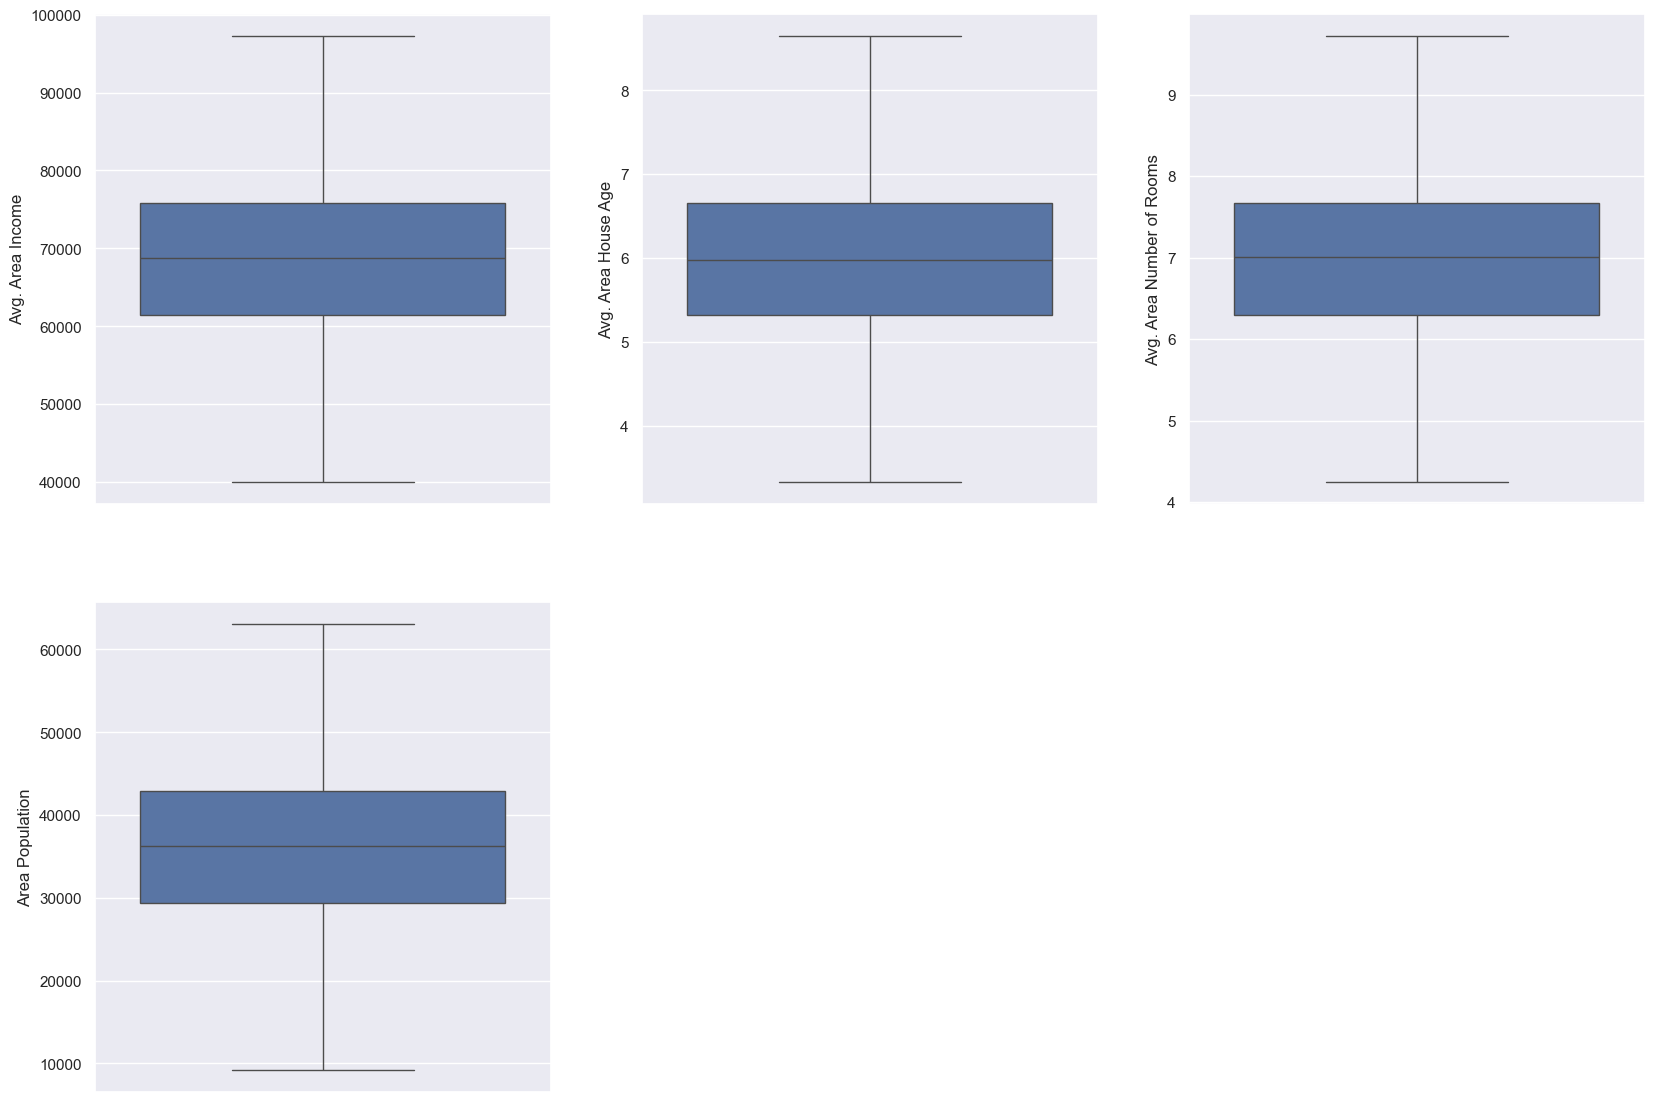

In [36]:
plt.figure(figsize=(20,14))
for i,j in enumerate(df_copy[['Avg. Area Income', 'Avg. Area House Age', 'Avg. Area Number of Rooms', 'Area Population']]):
    plt.subplot(2,3,i+1)
    sns.boxplot(data=df_copy[j])

# Preprocessing part 4 - Feature Scaling 

In [37]:
df_copy.drop(columns=['Address'],inplace=True)

### please note, when you use Gradient descent then 100% feature scaling is required
### For OLS, you have to check model is perfoming better with or without feature scaling and take action accordingly

In [38]:
X_train.drop(columns=['Address'],inplace=True)
X_test.drop(columns=['Address'],inplace=True)

In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaler = scaler.fit_transform(X_train)
x_test_scalar =scaler.transform(X_test)

In [40]:
# Preprocessing part
# 1) handling missing data - completed
# 2) handling encoding - completed
# 3) handling outlier - completed
# 4) feature scaling - completed
# 5) imbalance data - this is not applicable for linear regression

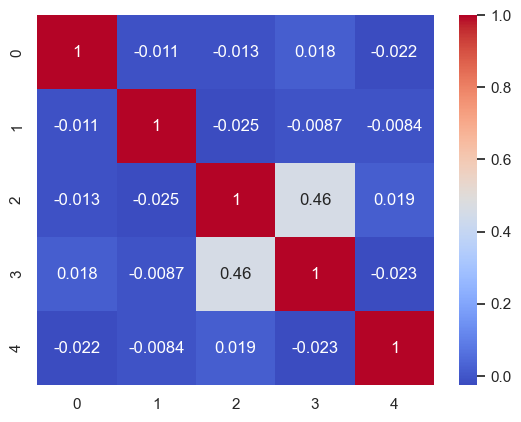

In [41]:

sns.heatmap(pd.DataFrame(x_train_scaler).corr(), annot=True, cmap='coolwarm')
plt.show()

# Variance Inflation Factor (VIF)

In [42]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

variable=x_train_scaler

df_vif=pd.DataFrame()

[variance_inflation_factor(variable,i) for i in range(variable.shape[1])]


[1.0014626557996986,
 1.0008270933878614,
 1.2666512398354075,
 1.2663876010965398,
 1.0021345742201313]

In [43]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

variable=x_test_scalar

df_vif=pd.DataFrame()

[variance_inflation_factor(variable,i) for i in range(variable.shape[1])]

[1.0011228675265356,
 1.0039755626050955,
 1.2931454566921188,
 1.293628471726044,
 1.0033015742730538]

In [44]:
# https://corporatefinanceinstitute.com/resources/data-science/variance-inflation-factor-vif/

In [46]:
from statsmodels.regression.linear_model import OLS

import statsmodels.regression.linear_model as smf

In [48]:
regression_model = smf.OLS(endog=Y_train, exog=X_train).fit()

In [49]:
regression_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Price   R-squared (uncentered):                   0.965
Model:                            OLS   Adj. R-squared (uncentered):              0.965
Method:                 Least Squares   F-statistic:                          1.903e+04
Date:                Sat, 13 Jan 2024   Prob (F-statistic):                        0.00
Time:                        13:31:16   Log-Likelihood:                         -48343.
No. Observations:                3500   AIC:                                  9.670e+04
Df Residuals:                    3495   BIC:                                  9.673e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Avg. Area Income                10.0993      0.321     31.490      0.000       9.470      10.728
Avg. Area House Age           5.119e+04   3497.804     14.634      0.000    4.43e+04     5.8e+04
Avg. Area Number of Rooms    -9032.3814   3901.784     -2.315      0.021   -1.67e+04   -1382.377
Avg. Area Number of Bedrooms  2489.6166   3736.947      0.666      0.505   -4837.202    9816.435
Area Population                  8.4312      0.392     21.486      0.000       7.662       9.201
==============================================================================
Omnibus:                        0.388   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.824   Jarque-Bera (JB):                0.435
Skew:                           0.017   Prob(JB):                        0.804
Kurtosis:                       2.957   Cond. No.                     9.30e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 9.3e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Avg. Area Number of Bedrooms is not significant, so we can remove that

In [51]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, Y_train)

LinearRegression()

In [57]:
X_train

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population
1334,59481.78201,4.776719,7.545438,4.31,31200.96783
4768,71663.05620,4.911607,7.211583,5.00,39241.82037
65,56547.50719,5.435415,6.515150,3.13,37585.27458
177,59513.83492,4.885132,5.574714,3.18,44162.27921
4489,63753.86424,8.112336,7.694745,6.35,31347.68978
...,...,...,...,...,...
2895,56734.35076,6.159101,8.280404,4.30,27982.27171
2763,50212.43953,6.645207,7.404114,5.44,20913.65544
905,80011.58352,6.448675,6.489268,2.49,26576.39199
3980,72899.65820,5.222040,6.861010,4.21,39311.14754


In [54]:
y_pred_train =lr.predict(X_train)
y_pred_test = lr.predict(X_test)

In [52]:
# evaluate the model
from sklearn.metrics import r2_score

In [58]:
print("Training Accuracy ", r2_score(Y_train, y_pred_train))
print("****************"*10)
print("Test Accuracy ", r2_score(Y_test, y_pred_test))

Training Accuracy  0.9177629973847751
****************************************************************************************************************************************************************
Test Accuracy  0.9143965869869124


## check for duplicate data

In [65]:
df_copy.duplicated().sum()  

0

# Assumptions

### Linearity


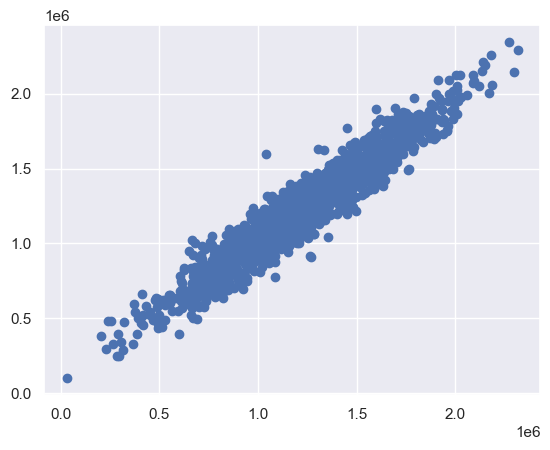

In [59]:
# Linearity
plt.scatter(Y_test, y_pred_test)

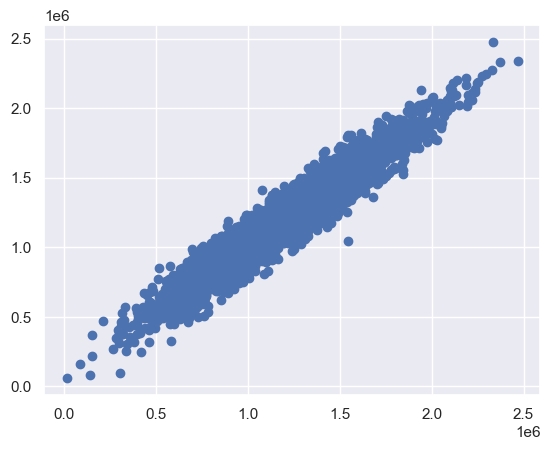

In [60]:
plt.scatter(Y_train, y_pred_train)

### Residual - normality


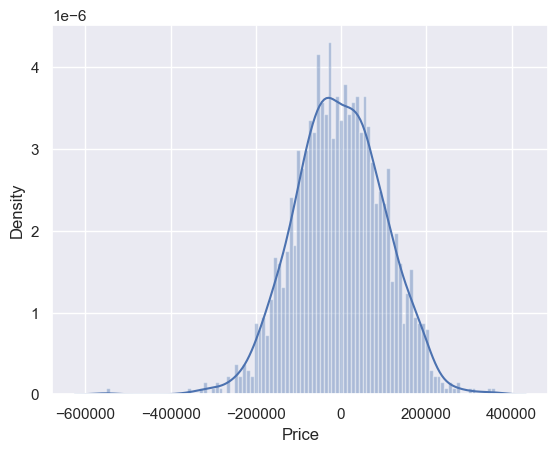

In [63]:
# Residual - normality

sns.distplot((Y_test - y_pred_test), bins=100)

plt.show()

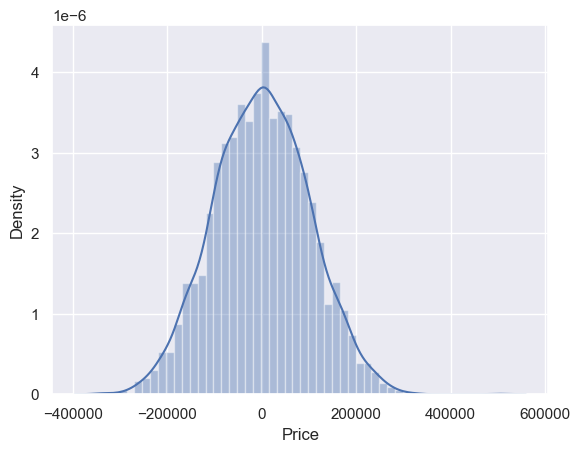

In [64]:
sns.distplot((Y_train - y_pred_train), bins=50)

plt.show()

In [ ]:
# Conclude :

# part 1 : R-Square and Adj-R-Square - satisfied
# part 2 - p_value - satisfied (please drop bedroom and try)
# part 3 - assumption :
    # a) no autocorrelation found - satisfied durbin watson [0-4]
    # b ) no multicollinearity found - satisfied
    # c) homoscediscity - satisfied (outlier treatement done)
    # d) normality of residual - satisfied
    # e) linearity relation with action dv vs pred dv - satisfied
    # f) no endogenity - satisfied (as taken right dv - price)

In [ ]:
# pending :
# MAE, MAPE, MSE, RMSE, Lasso, ridge, elasticNet, Gradient descent 
# cross validation 
# stats topic - t-test is pending

In [ ]:
# homewark - kaggle - adv housing price dataset
# https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques
# homework - AirBNB.csv (accuracy test is more than 70% by using linear regression - SILK)
# use linear regression model - 